In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/nimisha/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# This file is contains the score of differnt teams
# `output.csv` does not contain team information It only contains the Team and its score information
output = pd.read_csv('output.csv')


In [3]:
# Convert all the entities to lower case
output['name'] = output['name'].apply(lambda x: x.lower())

# remove all punctuations and spaces, now concatenate the string
output['name'] = output['name'].str.replace(r'\W+', '').astype('str')

#unnecessary column
output.drop(columns=['score2'],inplace = True)

#based on the value of the columns divide into different classes.
#output['isEff'] = np.where(output.score1 > 40, 'Yes' , 'No')
output['isEff'] = np.where(output.score1 > 40, np.where(output.score1 > 75, 'Yes' , 'Mod'), 'No')

output.team_id = output.team_id.astype(str)

In [4]:
# Create dictionaries
# Inorder to map the scores with the team Name

nameMap = dict(zip(output.name,output.isEff))
idMap = dict(zip(output.team_id,output.isEff))
idToNameMap = dict(zip(output.team_id,output.name))

In [5]:
# Read Data 
data = pd.read_csv('Data.csv')

# Adding the 'Temperament' Attribute
#data['Temperament'] = np.where(data.SI == 'Sensation',np.where(data.JP == 'Judgement','Gaurdian','Artisans'), np.where(data.TF == 'Feeling','Idealists','Rationals'))
data['Impact'] = np.where(data.workedEarlier == 'No' , np.where(data.workAgain == 'Yes', 'Positive' , 'Negative'), np.where(data.workAgain == 'Yes', 'Neutral' , 'Negative'))


In [6]:
# Create a new column isEff
# using the dictionary maps created earlier 
def isEff(data):
    data['isEff'] = data['teamName'].map(nameMap)
    data['teamName'] = np.where(data['teamName'].str.contains(pat = '^[0-9].*'),data['teamName'].map(idToNameMap), data['teamName'] )
    data['isEff'] = np.where(pd.isnull(data.isEff) ,data['teamName'].map(nameMap),data.isEff)
    data['isEff'] = np.where(pd.isnull(data.isEff) ,data['teamName'].map(idMap),data.isEff)
    #print(data[['teamName','isEff']])
    return data

# For grouping the names together, certain preprocessing has to be done
def teamNameProcessing(data):
    data['teamName'] = data['teamName'].astype('str').apply(lambda x: x.lower())
    data['teamName'] = data['teamName'].str.replace(r'\W+','').astype('str')
    

# Converting to yes or no Attributes
def convertToYesNo(data,attr,val):
    data[attr] = np.where(data[attr] >= val, 'Yes', 'No')

def percentage(x,val1,val2):
    c1 = 0
    c2 = 0
    for a in x:    
        if a == val1:
            c1=c1+1
        elif a == val2:
            c2=c2+1
            
    ratio = round(c1/(c1+c2),2)*100
    return ratio

def convertToTeamData(data,newAttr,oldAttr,val1,val2):
    data[newAttr] = data[oldAttr].str.split(',').apply(lambda x:sorted(x))
    data[newAttr] =  data[newAttr].apply(percentage, args = (val1,val2))
    return data


In [7]:
teamNameProcessing(data)

numerical = data.groupby('teamName').mean().reset_index()
numerical['SocialOrder'] =numerical[['equalContribution','appreciation','cooperation','freedom']].min(axis = 1)

convertToYesNo(numerical,'Difficulty',4)
convertToYesNo(numerical,'equalContribution',4)
convertToYesNo(numerical,'appreciation',4)
convertToYesNo(numerical,'cooperation',4)
convertToYesNo(numerical,'freedom',4)
convertToYesNo(numerical,'SocialOrder',4)
numerical.columns

Index(['teamName', 'Difficulty', 'equalContribution', 'appreciation',
       'cooperation', 'freedom', 'SocialOrder'],
      dtype='object')

In [8]:
categorical = data.groupby('teamName').agg(','.join).reset_index()

categorical['size'] = categorical['Gender'].str.split(',').str.len()
categorical = isEff(categorical)

categorical = convertToTeamData(categorical,'femalePercent','Gender','Female','Male')    
categorical = convertToTeamData(categorical,'IntrovertPercent','EI','Introvert','Extrovert')  
categorical = convertToTeamData(categorical,'IntuitionPercent','SI','Intuition','Sensation')
categorical = convertToTeamData(categorical,'ThinkingPercent','TF','Thinking','Feeling')
categorical = convertToTeamData(categorical,'JudgementPercent','JP','Judgement','Perception')  
categorical = convertToTeamData(categorical,'workedEarlierPercent','workedEarlier','Yes','No')  
categorical = convertToTeamData(categorical,'workAgainPercent','workAgain','Yes','No') 



In [9]:
categorical.drop(['Gender', 'Personality', 'EI', 'SI', 'TF', 'JP',
       'workedEarlier','workAgain','Temperament'],axis = 1,inplace = True)

def splitToThree(data,attr,val1,val2,cat):
    data[attr] = np.where(data[attr] <= val1, cat[0],  np.where(data[attr] <= val2, cat[1], cat[2]))

#categorical = categorical[categorical['isEff'] == 'Yes']
splitToThree(categorical,'femalePercent',33,50,['FPLow','FPLow','FPHigh'])
splitToThree(categorical,'IntrovertPercent',33,50,['IELow','IELow','IEHigh'])
splitToThree(categorical,'IntuitionPercent',33,50,['INLow','INLow','INHigh'])
splitToThree(categorical,'ThinkingPercent',33,50,['TFLow','TFLow','TFHigh'])
splitToThree(categorical,'JudgementPercent',33,50,['JPLow','JPLow','JPHigh'])
splitToThree(categorical,'workedEarlierPercent',33,50,['WELow','WELow','WEHigh'])
splitToThree(categorical,'workAgainPercent',33,50,['WALow','WALow','WAHigh'])

categorical.to_csv('FinalData.csv',index = False)

In [10]:
teams = pd.merge(numerical,categorical, on = 'teamName')
teams.drop(['Difficulty','teamName','Improvement'],axis = 1, inplace = True)
teams.to_csv('Sorted.csv',index = False)
print(teams.shape)

print(teams.apply(pd.Series.value_counts))

(78, 15)
                                     equalContribution  appreciation  \
3                                                  NaN           NaN   
4                                                  NaN           NaN   
FPHigh                                             NaN           NaN   
FPLow                                              NaN           NaN   
IEHigh                                             NaN           NaN   
IELow                                              NaN           NaN   
INHigh                                             NaN           NaN   
INLow                                              NaN           NaN   
JPHigh                                             NaN           NaN   
JPLow                                              NaN           NaN   
Mod                                                NaN           NaN   
Negative,Negative,Negative                         NaN           NaN   
Negative,Negative,Negative,Negative                NaN 

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
teams = teams.apply(preprocessing.LabelEncoder().fit_transform)

y = teams.isEff
X = teams.drop('isEff',axis=1)
feature_names = X.columns
class_name = {1:'Effective',0:'Not Effective',2:'Moderate'}
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20, random_state = 123)


The accuracy is: 0.625
Index(['equalContribution', 'appreciation', 'cooperation', 'freedom',
       'SocialOrder', 'Impact', 'size', 'femalePercent', 'IntrovertPercent',
       'IntuitionPercent', 'ThinkingPercent', 'JudgementPercent',
       'workedEarlierPercent', 'workAgainPercent'],
      dtype='object')


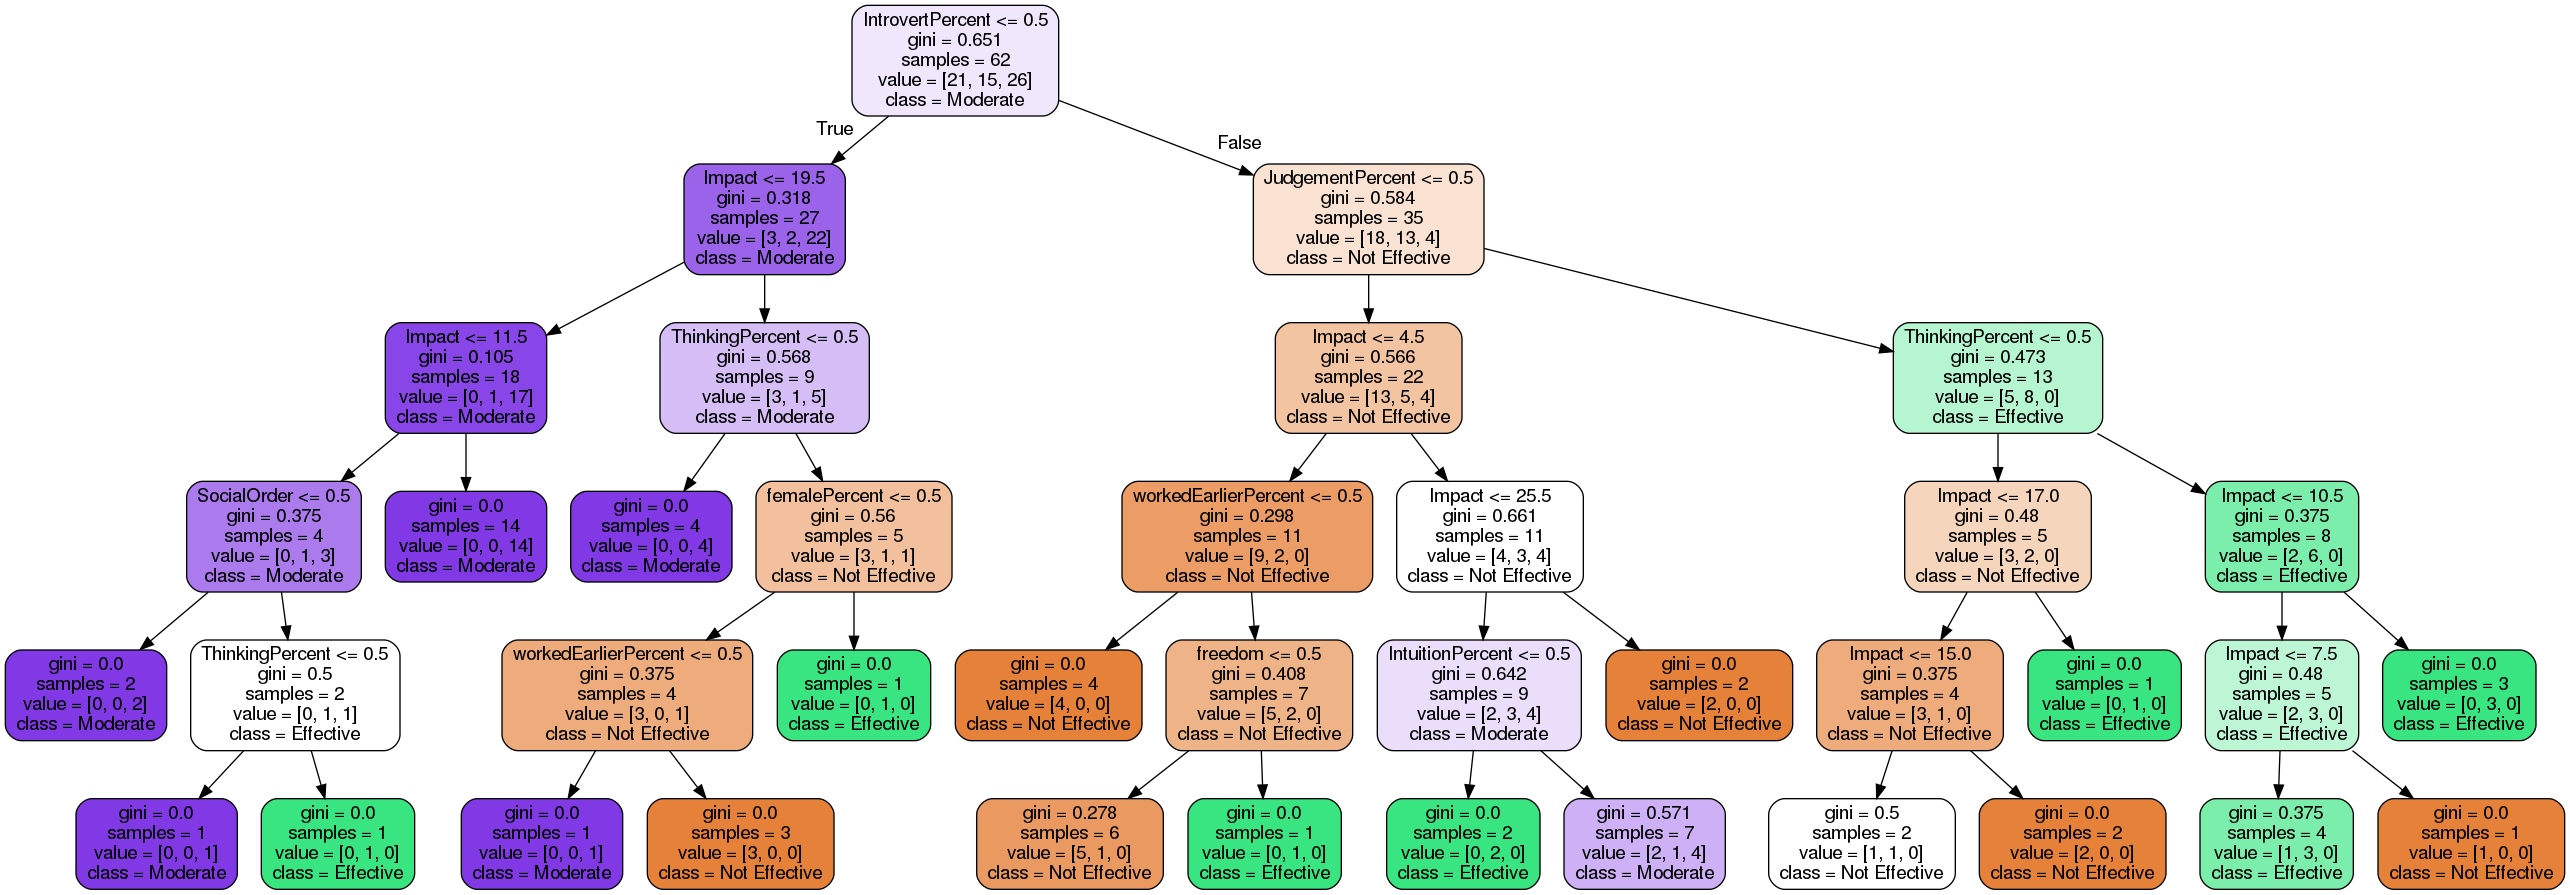

In [15]:
dt = DecisionTreeClassifier(criterion='gini', random_state = 1, max_depth=5)
dt.fit(train_X,train_y)
pred = dt.predict(test_X) 

from sklearn.metrics import accuracy_score

print('The accuracy is:',accuracy_score(test_y, pred))


from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus
dot_data = StringIO()

export_graphviz(dt,
                out_file=dot_data,
                filled=True,
                rounded=True,
                feature_names=feature_names,
                class_names=class_name)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
print(X.columns)
Image(graph.create_png())

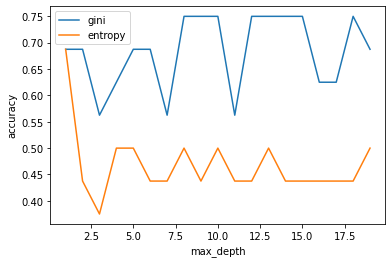

In [13]:
max_depth = []
acc_gini = []
acc_entropy = []

x_train, x_test, y_train, y_test = train_X, test_X, train_y, test_y 
for i in range(1,20):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(x_train, y_train)
    pred = dtree.predict(x_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ####
    
    dtree = DecisionTreeClassifier(criterion= 'entropy', max_depth=i)
    dtree.fit(x_train, y_train)
    pred = dtree.predict(x_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
    d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
                      'acc_entropy':pd.Series(acc_entropy),
                      'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini',data = d, label = 'gini')
plt.plot('max_depth','acc_entropy', data= d, label='entropy')

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

import json,csv
file = open('../Data/teams.json')
data = json.load(file)
output = open('../Data/output.csv','w')
op = csv.writer(output)
f = 0
for d in data:
    if f == 0:
        header = d.keys()
        head = []
        a = ''
        for h in header:
            head.append(h)
        
        header  = ','.join(head)
        op.writerow(head)
        
        print(a)
        f += 1
    else:
        
        row = d.values()
        #print(type(row))
        #op.writerow(row)
file.close()
row = ['team_id','name','room','score1','score2']
with open('output.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(row)
    rows = []
    for d in data:
        row = []
        row.append(d['team_id'])
        row.append(d['name'])
        row.append(d['room'])
        info = d['scores'][0]
        if len(info) == 0:
            print(d)
            data.remove(d)
        elif len(info) != 3:
            for i in range(len(info)):
                score1 = info[i]['score']
                row.append(score1)
        rows.append(row)
        writer.writerow(row)
csvFile.close()



#nameMap = output.groupby('name')['isEff'].apply(list).to_dict()
#idMap = output.groupby('team_id')['isEff'].apply(list).to_dict()
#IdToNameMap = output.groupby('team_id')['name'].apply(list).to_dict()


data1 = data1.rename(columns = {'Team Number':'teamName',
                                'Email address':'email',
                                'Member Contribution:':'equalContribution',
                                'Extrovert / Introvert:':'EI',
                                'Sensation / Intuition:':'SI',
                                'Thinking / Feeling:':'TF',
                                'Judgement / Perception:':'JP',
                                'Do you wish to Work with the same team again?':'workAgain',
                                'To what extent can your project be improved?':'howMuchImproved',
                               'Have you worked with your team earlier in any other project?':'workedEarlier',
                                'Would you like to work with your team again?':'workAgain',
                               'Difficulty Level of your project :':'Difficulty',
                                'Can your project be improved further?':'Improvement',
                               'What kind of improvement do you wish to make?':'whatImprovement',
                                'Team members have made equal contributions to the project:':'equalContribution',
                               "Team members appreciate one another's unique capability":'appreciation',
                                "Team members are cooperative (agree with one another's opinions, consistently help each other and are effective listeners):":'cooperation',
                               'It is easy to talk openly to all members of your group':'freedom',
                                'Additional comments':'comments',
                               'Are you a Team Leader?':'TeamLead',
                               'Domain of your Project:':'Domain'})

data1.sort_values(by = 'teamName').to_csv('TeamPerformance2.csv',index = False)

data2 = data2.rename(columns = {'Team Number':'teamName',
                                'Personality type (Example: ENTJ-A)':'Personality',
                                'Email address':'email',
                                'Extrovert / Introvert:':'EI',
                                'Sensation / Intuition:':'SI',
                                'Thinking / Feeling:':'TF',
                                'Judgement / Perception:':'JP',
                                'Do you wish to Work with the same team again?':'workAgain',
                                'To what extent can your project be improved?':'howMuchImproved',
                               'Have you worked with your team earlier in any other project?':'workedEarlier',
                                'Would you like to work with your team again?':'workAgain',
                               'Difficulty Level of your project :':'Difficulty',
                                'Can your project be improved further?':'Improvement',
                               'What kind of improvement do you wish to make?':'whatImprovement',
                                'Team members have made equal contributions to the project:':'equalContribution',
                               "Team members appreciate one another's unique capability":'appreciation',
                                "Team members are cooperative (agree with one another's opinions, consistently help each other and are effective listeners):":'cooperation',
                               'It is easy to talk openly to all members of your group':'freedom',
                                'Additional comments':'comments'})

data2.sort_values(by = 'teamName').to_csv('TeamPerformance2.csv', index = False)
